# Leverage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix

In [2]:
path = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(path)

In [29]:
# レバレッジの計算
class LeverageCalculator:
    def __init__(self, X, data):
        self.X = X
        self.data = data

    def get_leverage(self):
        # ハット行列 H の計算
        H = self.X @ np.linalg.inv(self.X.T @ self.X) @ self.X.T
        # 対角要素を取得
        leverage = np.diag(H)

        self.data['leverage'] = leverage

        return self.data

    def plot_leverage(self, figsize=(10, 5)):
        if 'leverage' not in self.data.columns:
            self.get_leverage()

        mean_leverage = self.data['leverage'].mean()

        fig, ax = plt.subplots(figsize=figsize)
        sns.scatterplot(
            x=self.data.index,
            y='leverage',
            data=self.data,
            color='black',
            ax=ax
        )
        ax.set_xlabel('Index')
        ax.set_ylabel('Leverage')
        ax.set_title('Leverage')
        ax.axhline(mean_leverage, color='black', linestyle='--', label='Mean')
        ax.axhline(2 * mean_leverage, color='black', linestyle='-.', label='2 * Mean')
        ax.legend()

        return fig, ax

SyntaxError: invalid syntax (267848145.py, line 35)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Leverage'}, xlabel='Index', ylabel='Leverage'>)

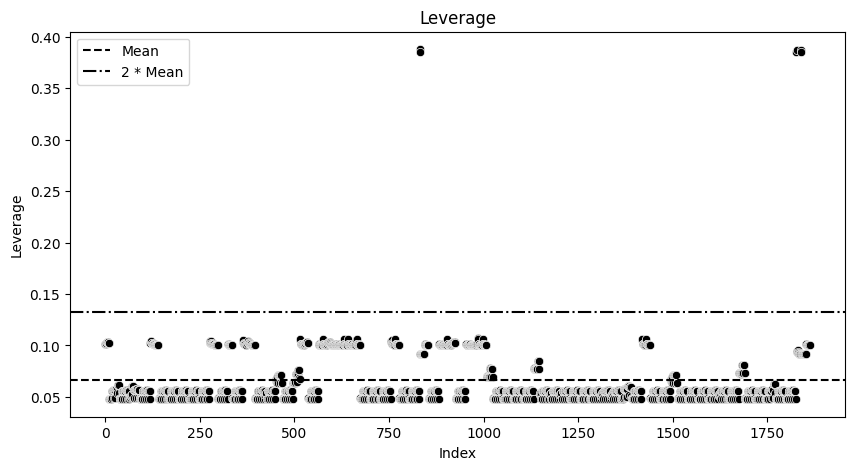

In [28]:
X = dmatrix('C(island_ids) + C(year) + after_treatment -1', df)

calculator = LeverageCalculator(X, df)
calculator.plot_leverage()

In [9]:
mean_leverage = df_leverage['leverage'].mean()
print(f'平均レバレッジ: {mean_leverage:.4f}')

k = X.shape[1]
n = df.shape[0]
theoretical_value = (k+1) / n
print(f'平均レバレッジの理論値: {theoretical_value:.4f}')

平均レバレッジ: 0.0660
平均レバレッジの理論値: 0.0666


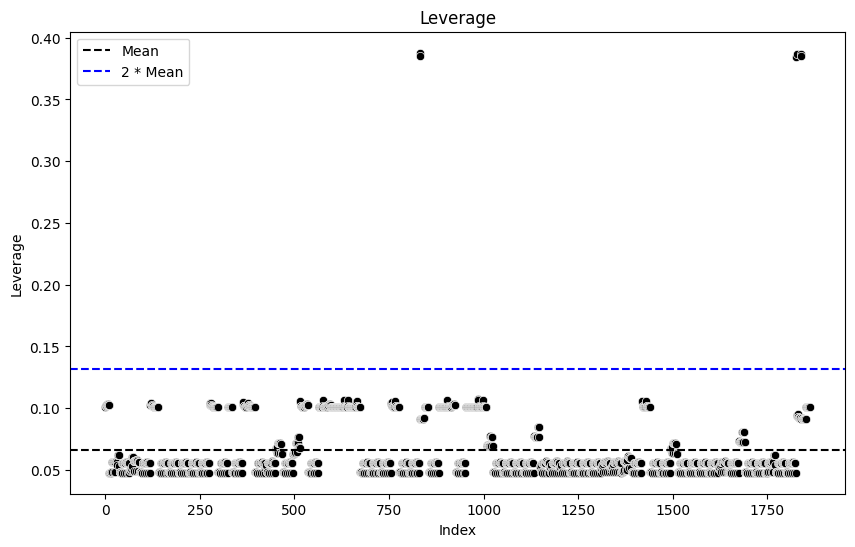

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_leverage.index, y='leverage', data=df_leverage, color='black')
plt.xlabel('Index')
plt.ylabel('Leverage')
plt.title('Leverage')
plt.axhline(mean_leverage, color='black', linestyle='--', label='Mean')
plt.axhline(2 *mean_leverage, color='blue', linestyle='--', label='2 * Mean')
plt.legend()
plt.show()

In [79]:
df['leverage'].max()
2 * mean_leverage

array(0.13789474)

In [80]:
len(df[df['leverage'] > 2 * theoretical_value]) / len(df)

0.022631578947368423